In [62]:
functions = [#"compression",
    #"dynamic-html",
    #"graph-bfs",
    #"graph-mst",
    # "pagerank",
    "thumbnailer",
    # "video-processing"
]

In [63]:
import pathlib
import pandas as pd
import iso8601.iso8601
import datetime
import matplotlib.pyplot as plt
import collections
import tqdm
import itertools
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=FutureWarning)


def round(t):
    t = datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second, t.microsecond)
    return t


def makehash():
    return collections.defaultdict(makehash)


data_dir = pathlib.Path("LongTests")
nep_dir = data_dir.joinpath("neptune")
run_dirs = [nep_dir]

runs = list(range(3))


# for run in runs:

#function = "compression"
run = 4

result = makehash()

for run_dir, function, run_n in tqdm.tqdm(list(itertools.product(run_dirs, functions, runs))):
    req_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_proxy_metric.csv"))
    req_df['timestamp'] = req_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    req_df['timestamp'] = req_df['timestamp'].map(round)
    min_time = min(req_df['timestamp'])
    max_time = max(req_df['timestamp'])
    req_df['timestamp'] = req_df['timestamp'] - min_time
    req_df = req_df.sort_values('timestamp')

    res_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_pod_log.csv"))
    res_df = res_df[res_df["container_name"].map(lambda x: function in x)]
    res_df['timestamp'] = res_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    res_df['timestamp'] = res_df['timestamp'].map(round)
    res_df = res_df[res_df['timestamp'] < max_time]
    res_df = res_df[res_df['timestamp'] > min_time]
    res_df['timestamp'] = res_df['timestamp'] - min_time
    res_df = res_df.sort_values('timestamp')

    # if run_dir is crh_dir:
    #     res_df = res_df[~res_df['pod_address'].isna()]
    # if run_dir is cro_dir:
    #     res_df['cpu'] = res_df['cpu'] + np.random.normal(0, 0.5, len(res_df['cpu']))

    cpu = res_df.groupby("timestamp").sum()['cpu'].rolling(20, win_type="triang", min_periods=20).mean()
    rt = req_df.groupby("timestamp").mean()['latency'].rolling(20, win_type="triang", min_periods=20).mean()

    result[run_dir][function]['cpu'][run_n] = cpu.to_numpy()
    result[run_dir][function]['rt'][run_n] = rt.to_numpy()

stats_req = pd.DataFrame()
data_nept = []
for i, function in enumerate(functions):
    for run_dir in run_dirs:
        run_arr = np.concatenate(list(result[run_dir][function]['rt'].values()))
        run_arr = run_arr[~np.isnan(run_arr)]
        data_nept += [run_arr]
        stats_req = stats_req.append({
            'function': function,
            'approach': run_dir,
            'sum': sum(run_arr > (200 if function != "video-processing" else 20000)),
            'len': len(run_arr),
            'mean': np.mean(run_arr),#sum(run_arr)/len(run_arr),
            'median': np.median(run_arr),
            'std': np.std(run_arr),
            'mse': np.mean(np.abs(run_arr - 100)),
            'ratio': sum(run_arr > (200 if function != "video-processing" else 20000)) / len(run_arr)
        }, ignore_index=True)


100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


In [64]:
warnings.simplefilter(action='ignore', category=FutureWarning)

def round(t):
    t = datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second, t.microsecond)
    return t


def makehash():
    return collections.defaultdict(makehash)


data_dir = pathlib.Path("LongTests")
vsvbp_dir = data_dir.joinpath("vsvbp")
run_dirs = [nep_dir]
runs = list(range(3))

run = 4

result = makehash()

for run_dir, function, run_n in tqdm.tqdm(list(itertools.product(run_dirs, functions, runs))):
    req_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_proxy_metric.csv"))
    req_df['timestamp'] = req_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    req_df['timestamp'] = req_df['timestamp'].map(round)
    min_time = min(req_df['timestamp'])
    max_time = max(req_df['timestamp'])
    req_df['timestamp'] = req_df['timestamp'] - min_time
    req_df = req_df.sort_values('timestamp')

    res_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_pod_log.csv"))
    res_df = res_df[res_df["container_name"].map(lambda x: function in x)]
    res_df['timestamp'] = res_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    res_df['timestamp'] = res_df['timestamp'].map(round)
    res_df = res_df[res_df['timestamp'] < max_time]
    res_df = res_df[res_df['timestamp'] > min_time]
    res_df['timestamp'] = res_df['timestamp'] - min_time
    res_df = res_df.sort_values('timestamp')

    cpu = res_df.groupby("timestamp").sum()['cpu'].rolling(20, win_type="triang", min_periods=20).mean()
    rt = req_df.groupby("timestamp").mean()['latency'].rolling(20, win_type="triang", min_periods=20).mean()

    result[run_dir][function]['cpu'][run_n] = cpu.to_numpy()
    result[run_dir][function]['rt'][run_n] = rt.to_numpy()

stats_req = pd.DataFrame()
data_vsvbp=[]
for i, function in enumerate(functions):
    data_vsvbp = []
    for run_dir in run_dirs:
        run_arr = np.concatenate(list(result[run_dir][function]['rt'].values()))
        run_arr = run_arr[~np.isnan(run_arr)]
        data_nept += [run_arr]
        stats_req = stats_req.append({
            'function': function,
            'approach': run_dir,
            'sum': sum(run_arr > (200 if function != "video-processing" else 20000)),
            'len': len(run_arr),
            'mean': np.mean(run_arr),#sum(run_arr)/len(run_arr),
            'median': np.median(run_arr),
            'std': np.std(run_arr),
            'mse': np.mean(np.abs(run_arr - 100)),
            'ratio': sum(run_arr > (200 if function != "video-processing" else 20000)) / len(run_arr)
        }, ignore_index=True)


100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


In [65]:
warnings.simplefilter(action='ignore', category=FutureWarning)

def round(t):
    t = datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second, t.microsecond)
    return t


def makehash():
    return collections.defaultdict(makehash)


data_dir = pathlib.Path("LongTests")
vsvbp_dir = data_dir.joinpath("vsvbp")
run_dirs = [vsvbp_dir]
runs = list(range(3))

run = 4

result = makehash()

for run_dir, function, run_n in tqdm.tqdm(list(itertools.product(run_dirs, functions, runs))):
    req_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_proxy_metric.csv"))
    req_df['timestamp'] = req_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    req_df['timestamp'] = req_df['timestamp'].map(round)
    min_time = min(req_df['timestamp'])
    max_time = max(req_df['timestamp'])
    req_df['timestamp'] = req_df['timestamp'] - min_time
    req_df = req_df.sort_values('timestamp')

    res_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_pod_log.csv"))
    res_df = res_df[res_df["container_name"].map(lambda x: function in x)]
    res_df['timestamp'] = res_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    res_df['timestamp'] = res_df['timestamp'].map(round)
    res_df = res_df[res_df['timestamp'] < max_time]
    res_df = res_df[res_df['timestamp'] > min_time]
    res_df['timestamp'] = res_df['timestamp'] - min_time
    res_df = res_df.sort_values('timestamp')



    cpu = res_df.groupby("timestamp").sum()['cpu'].rolling(20, win_type="triang", min_periods=20).mean()
    rt = req_df.groupby("timestamp").mean()['latency'].rolling(20, win_type="triang", min_periods=20).mean()

    result[run_dir][function]['cpu'][run_n] = cpu.to_numpy()
    result[run_dir][function]['rt'][run_n] = rt.to_numpy()

stats_req = pd.DataFrame()
data_vsvbp=[]
for i, function in enumerate(functions):
    data_vsvbp = []
    for run_dir in run_dirs:
        run_arr = np.concatenate(list(result[run_dir][function]['rt'].values()))
        run_arr = run_arr[~np.isnan(run_arr)]
        data_vsvbp += [run_arr]
        stats_req = stats_req.append({
            'function': function,
            'approach': run_dir,
            'sum': sum(run_arr > (200 if function != "video-processing" else 20000)),
            'len': len(run_arr),
            'mean': np.mean(run_arr),#sum(run_arr)/len(run_arr),
            'median': np.median(run_arr),
            'std': np.std(run_arr),
            'mse': np.mean(np.abs(run_arr - 100)),
            'ratio': sum(run_arr > (200 if function != "video-processing" else 20000)) / len(run_arr)
        }, ignore_index=True)


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


In [66]:
warnings.simplefilter(action='ignore', category=FutureWarning)

def round(t):
    t = datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second, t.microsecond)
    return t


def makehash():
    return collections.defaultdict(makehash)


data_dir = pathlib.Path("LongTests")
#crh_dir = data_dir.joinpath("cr-h")
#cro_dir = data_dir.joinpath("cr-o")
mcf_dir = data_dir.joinpath("mcf")
#nep_dir = data_dir.joinpath("neptune")
#vsvbp_dir = data_dir.joinpath("vsvbp")
run_dirs = [mcf_dir]
runs = list(range(3))

run = 4

result = makehash()

for run_dir, function, run_n in tqdm.tqdm(list(itertools.product(run_dirs, functions, runs))):
    req_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_proxy_metric.csv"))
    req_df['timestamp'] = req_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    req_df['timestamp'] = req_df['timestamp'].map(round)
    min_time = min(req_df['timestamp'])
    max_time = max(req_df['timestamp'])
    req_df['timestamp'] = req_df['timestamp'] - min_time
    req_df = req_df.sort_values('timestamp')

    res_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_pod_log.csv"))
    res_df = res_df[res_df["container_name"].map(lambda x: function in x)]
    res_df['timestamp'] = res_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    res_df['timestamp'] = res_df['timestamp'].map(round)
    res_df = res_df[res_df['timestamp'] < max_time]
    res_df = res_df[res_df['timestamp'] > min_time]
    res_df['timestamp'] = res_df['timestamp'] - min_time
    res_df = res_df.sort_values('timestamp')

    cpu = res_df.groupby("timestamp").sum()['cpu'].rolling(20, win_type="triang", min_periods=20).mean()
    rt = req_df.groupby("timestamp").mean()['latency'].rolling(20, win_type="triang", min_periods=20).mean()

    result[run_dir][function]['cpu'][run_n] = cpu.to_numpy()
    result[run_dir][function]['rt'][run_n] = rt.to_numpy()

stats_req = pd.DataFrame()
for i, function in enumerate(functions):
    data_mcf = []
    for run_dir in run_dirs:
        run_arr = np.concatenate(list(result[run_dir][function]['rt'].values()))
        run_arr = run_arr[~np.isnan(run_arr)]
        data_mcf += [run_arr]
        stats_req = stats_req.append({
            'function': function,
            'approach': run_dir,
            'sum': sum(run_arr > (200 if function != "video-processing" else 20000)),
            'len': len(run_arr),
            'mean': np.mean(run_arr),#sum(run_arr)/len(run_arr),
            'median': np.median(run_arr),
            'std': np.std(run_arr),
            'mse': np.mean(np.abs(run_arr - 100)),
            'ratio': sum(run_arr > (200 if function != "video-processing" else 20000)) / len(run_arr)
        }, ignore_index=True)


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


In [67]:
warnings.simplefilter(action='ignore', category=FutureWarning)

def round(t):
    t = datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second, t.microsecond)
    return t


def makehash():
    return collections.defaultdict(makehash)


data_dir = pathlib.Path("LongTests")
#crh_dir = data_dir.joinpath("cr-h")
cro_dir = data_dir.joinpath("cr-o")
#mcf_dir = data_dir.joinpath("mcf")
#nep_dir = data_dir.joinpath("neptune")
#vsvbp_dir = data_dir.joinpath("vsvbp")
run_dirs = [cro_dir]
runs = list(range(3))

run = 4

result = makehash()

for run_dir, function, run_n in tqdm.tqdm(list(itertools.product(run_dirs, functions, runs))):
    req_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_proxy_metric.csv"))
    req_df['timestamp'] = req_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    req_df['timestamp'] = req_df['timestamp'].map(round)
    min_time = min(req_df['timestamp'])
    max_time = max(req_df['timestamp'])
    req_df['timestamp'] = req_df['timestamp'] - min_time
    req_df = req_df.sort_values('timestamp')

    res_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_pod_log.csv"))
    res_df = res_df[res_df["container_name"].map(lambda x: function in x)]
    res_df['timestamp'] = res_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    res_df['timestamp'] = res_df['timestamp'].map(round)
    res_df = res_df[res_df['timestamp'] < max_time]
    res_df = res_df[res_df['timestamp'] > min_time]
    res_df['timestamp'] = res_df['timestamp'] - min_time
    res_df = res_df.sort_values('timestamp')

    cpu = res_df.groupby("timestamp").sum()['cpu'].rolling(20, win_type="triang", min_periods=20).mean()
    rt = req_df.groupby("timestamp").mean()['latency'].rolling(20, win_type="triang", min_periods=20).mean()

    result[run_dir][function]['cpu'][run_n] = cpu.to_numpy()
    result[run_dir][function]['rt'][run_n] = rt.to_numpy()

stats_req = pd.DataFrame()
for i, function in enumerate(functions):
    data_cro = []
    for run_dir in run_dirs:
        run_arr = np.concatenate(list(result[run_dir][function]['rt'].values()))
        run_arr = run_arr[~np.isnan(run_arr)]
        data_cro += [run_arr]
        stats_req = stats_req.append({
            'function': function,
            'approach': run_dir,
            'sum': sum(run_arr > (200 if function != "video-processing" else 20000)),
            'len': len(run_arr),
            'mean': np.mean(run_arr),#sum(run_arr)/len(run_arr),
            'median': np.median(run_arr),
            'std': np.std(run_arr),
            'mse': np.mean(np.abs(run_arr - 100)),
            'ratio': sum(run_arr > (200 if function != "video-processing" else 20000)) / len(run_arr)
        }, ignore_index=True)


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


KeyboardInterrupt: 

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

def round(t):
    t = datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second, t.microsecond)
    return t


def makehash():
    return collections.defaultdict(makehash)


data_dir = pathlib.Path("LongTests")
crh_dir = data_dir.joinpath("cr-h")
#cro_dir = data_dir.joinpath("cr-o")
#mcf_dir = data_dir.joinpath("mcf")
#nep_dir = data_dir.joinpath("neptune")
#vsvbp_dir = data_dir.joinpath("vsvbp")
run_dirs = [crh_dir]
runs = list(range(3))

run = 4

result = makehash()

for run_dir, function, run_n in tqdm.tqdm(list(itertools.product(run_dirs, functions, runs))):
    req_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_proxy_metric.csv"))
    req_df['timestamp'] = req_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    req_df['timestamp'] = req_df['timestamp'].map(round)
    min_time = min(req_df['timestamp'])
    max_time = max(req_df['timestamp'])
    req_df['timestamp'] = req_df['timestamp'] - min_time
    req_df = req_df.sort_values('timestamp')

    res_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_pod_log.csv"))
    res_df = res_df[res_df["container_name"].map(lambda x: function in x)]
    res_df['timestamp'] = res_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    res_df['timestamp'] = res_df['timestamp'].map(round)
    res_df = res_df[res_df['timestamp'] < max_time]
    res_df = res_df[res_df['timestamp'] > min_time]
    res_df['timestamp'] = res_df['timestamp'] - min_time
    res_df = res_df.sort_values('timestamp')

    cpu = res_df.groupby("timestamp").sum()['cpu'].rolling(20, win_type="triang", min_periods=20).mean()
    rt = req_df.groupby("timestamp").mean()['latency'].rolling(20, win_type="triang", min_periods=20).mean()

    result[run_dir][function]['cpu'][run_n] = cpu.to_numpy()
    result[run_dir][function]['rt'][run_n] = rt.to_numpy()

stats_req = pd.DataFrame()
for i, function in enumerate(functions):
    data_crh = []
    for run_dir in run_dirs:
        run_arr = np.concatenate(list(result[run_dir][function]['rt'].values()))
        run_arr = run_arr[~np.isnan(run_arr)]
        data_crh += [run_arr]
        stats_req = stats_req.append({
            'function': function,
            'approach': run_dir,
            'sum': sum(run_arr > (200 if function != "video-processing" else 20000)),
            'len': len(run_arr),
            'mean': np.mean(run_arr),#sum(run_arr)/len(run_arr),
            'median': np.median(run_arr),
            'std': np.std(run_arr),
            'mse': np.mean(np.abs(run_arr - 100)),
            'ratio': sum(run_arr > (200 if function != "video-processing" else 20000)) / len(run_arr)
        }, ignore_index=True)



100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


In [ ]:
# # fig, ax = plt.subplots(1, 2)
# # ax[0].hist(data_nept)
# # ax[1].hist(data_vsvbp)
# # ax[0].set_xlim[200]
# plt.rcParams["figure.figsize"] = (20,3)
# ax1 = plt.subplot(131)

# ax1.hist(data_nept,color='blue')
# ax1.vlines(np.mean(data_nept),ymin=0,ymax=50000,colors='red')
# ax1.set_xlim([0, 2000])


# ax2 = plt.subplot(132)
# ax2.hist(data_vsvbp)
# ax2.vlines(np.mean(data_vsvbp),ymin=0,ymax=50000,colors='red')
# ax2.set_xlim([-2000, 2000])

Text(0.5, 0, 'Response time [ms]')

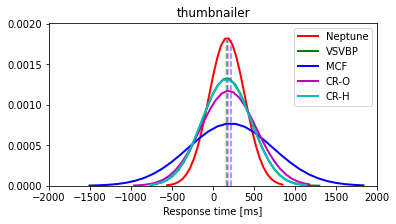

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)
ax1 = plt.subplot(131)
mu_neptune = np.mean(data_nept)
sigma_neptune = np.std(data_nept) #You manually calculated it but you can also use this built-in function
s_neptune = np.random.normal(mu_neptune, sigma_neptune, 1000)

mu_vsvbp = np.mean(data_vsvbp)
sigma_vsvbp = np.std(data_vsvbp) #You manually calculated it but you can also use this built-in function
s_vsvbp = np.random.normal(mu_vsvbp, sigma_vsvbp, 1000)

mu_mcf = np.mean(data_mcf)
sigma_mcf = np.std(data_mcf) #You manually calculated it but you can also use this built-in function
s_mcf = np.random.normal(mu_mcf, sigma_mcf, 1000)

mu_cro = np.mean(data_cro)
sigma_cro= np.std(data_cro) #You manually calculated it but you can also use this built-in function
s_cro = np.random.normal(mu_cro, sigma_cro, 1000)

mu_crh = np.mean(data_crh)
sigma_crh= np.std(data_crh) #You manually calculated it but you can also use this built-in function
s_crh = np.random.normal(mu_crh, sigma_crh, 1000)

countn, binsn, ignoredn = plt.hist(s_neptune, 30, density=True,alpha=0)
countv, binsv, ignoredv = plt.hist(s_vsvbp, 30, density=True,alpha=0)
countm, binsm, ignoredm = plt.hist(s_mcf, 30, density=True,alpha=0)
counto, binso, ignoredo = plt.hist(s_cro, 30, density=True,alpha=0)
counth, binsh, ignoredh = plt.hist(s_crh, 30, density=True,alpha=0)
ax1.plot(binsn, 1/(sigma_neptune * np.sqrt(2 * np.pi)) *
               np.exp( - (binsn - mu_neptune)**2 / (2 * sigma_neptune**2) ),
         linewidth=2, color='r',label='Neptune')
ax1.plot(binsv, 1/(sigma_vsvbp * np.sqrt(2 * np.pi)) *
               np.exp( - (binsv - mu_vsvbp)**2 / (2 * sigma_vsvbp**2) ),
         linewidth=2, color='g',label='VSVBP')
ax1.plot(binsm, 1/(sigma_mcf * np.sqrt(2 * np.pi)) *
               np.exp( - (binsm - mu_mcf)**2 / (2 * sigma_mcf**2) ),
         linewidth=2, color='b',label='MCF')
ax1.plot(binso, 1/(sigma_cro * np.sqrt(2 * np.pi)) *
               np.exp( - (binso - mu_cro)**2 / (2 * sigma_cro**2) ),
         linewidth=2, color='m',label='CR-O')
ax1.plot(binsh, 1/(sigma_crh * np.sqrt(2 * np.pi)) *
               np.exp( - (binsh - mu_crh)**2 / (2 * sigma_crh**2) ),
         linewidth=2, color='c',label='CR-H')
ax1.vlines(np.mean(data_nept),ymin=0,ymax=0.0018,colors='red',linestyles='dashed',alpha=0.5)
ax1.vlines(np.mean(data_vsvbp),ymin=0,ymax=0.0018,colors='green',linestyles='dashed',alpha=0.5)
ax1.vlines(np.mean(data_mcf),ymin=0,ymax=0.0018,colors='blue',linestyles='dashed',alpha=0.5)
ax1.vlines(np.mean(data_cro),ymin=0,ymax=0.0018,colors='magenta',linestyles='dashed',alpha=0.5)
ax1.vlines(np.mean(data_crh),ymin=0,ymax=0.0018,colors='cyan',linestyles='dashed',alpha=0.5)
ax1.legend()
ax1.set_xlim([-2000,2000])
ax1.set_title(function)
ax1.set_xlabel('Response time [ms]')

# ax2.plot(binsv, 1/(sigma_vsvbp * np.sqrt(2 * np.pi)) *
#                np.exp( - (binsv - mu_vsvbp)**2 / (2 * sigma_vsvbp**2) ),
#          linewidth=2, color='r')
# ax2.vlines(np.mean(data_vsvbp),ymin=0,ymax=0.00150,colors='green',linestyles='dashed')

(-40.0, 400.0)

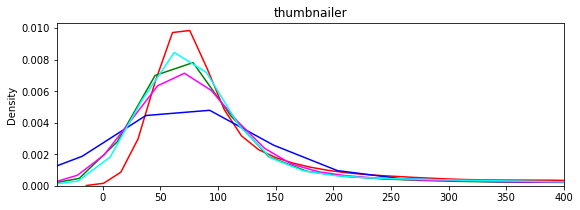

In [ ]:
import seaborn as sns
plt.subplot(1,2,1)
#sns.distplot(a=data_nept,hist=True, color='red',hist_kws={"edgecolor": 'white'},rug=False)
sns.distplot(data_nept,kde=True,hist=False,rug=False,hist_kws=dict(edgecolor="k", linewidth=2),color='red',label='Neptune')
# sns.distplot(a=data_vsvbp,hist=True, color='green',hist_kws={"edgecolor": 'white'},rug=False)
sns.distplot(data_vsvbp,kde=True,hist=False,rug=False,hist_kws=dict(edgecolor="k", linewidth=2),color='green',label='VSVBP')
# sns.distplot(a=data_mcf,hist=True, color='blue',hist_kws={"edgecolor": 'white'},rug=False)
sns.distplot(data_mcf,kde=True,hist=False,rug=False,hist_kws=dict(edgecolor="k", linewidth=2),color='blue',label='MCF')
# sns.distplot(a=data_cro,hist=True, color='magenta',hist_kws={"edgecolor": 'white'},rug=False)
sns.distplot(data_cro,kde=True,hist=False,rug=False,hist_kws=dict(edgecolor="k", linewidth=2),color='magenta',label='CR-O')
# sns.distplot(a=data_crh,hist=True, color='cyan',hist_kws={"edgecolor": 'white'},rug=False)
sns.distplot(data_crh,kde=True,hist=False,rug=False,hist_kws=dict(edgecolor="k", linewidth=2),color='cyan',label='CR-H')
plt.title(function)
plt.xlim([-40,400])


In [ ]:
# import seaborn as sns
# plt.subplot(1,2,1)
# plt.boxplot(data_nept,showfliers=False)
# plt.subplot(1,2,2)
# plt.boxplot(data_vsvbp,showfliers=False)

In [ ]:
# from scipy.stats import lognorm 
# import matplotlib.pyplot as plt
# import math 
# mu, sigma = np.mean(data_nept), np.std(data_nept) # mean and standard deviation
# s = lognorm.rvs(s=sigma/1000,scale=math.exp(mean/1000),size=2000)


# count, bins, ignored = plt.hist(s, 1000, density=True, align='mid')
# x = np.linspace(min(bins), max(bins), 10000)
# pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
#        / (x * sigma * np.sqrt(2 * np.pi)))
# plt.plot(x, pdf, linewidth=2, color='r')

# plt.show()

(0.0, 2.5)

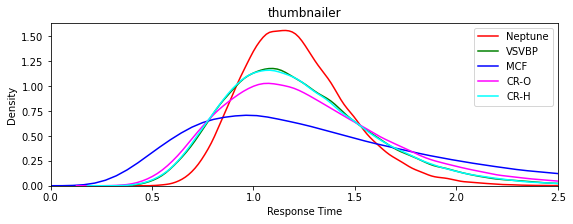

In [ ]:
from scipy.stats import lognorm 
import math 
plt.subplot(1,2,1)
stddev_n = np.std(data_nept) 
mean_n = np.mean(data_nept) 
lognorm_values_n = lognorm.rvs(s=stddev_n/1000, scale=math.exp(mean_n/1000), size=100000)
sns.distplot(lognorm_values_n,color='red',hist=False,label='Neptune')
stddev_v = np.std(data_vsvbp) 
mean_v = np.mean(data_vsvbp) 
lognorm_values_v = lognorm.rvs(s=stddev_v/1000, scale=math.exp(mean_v/1000), size=100000)
sns.distplot(lognorm_values_v,color='green',hist=False,label='VSVBP')
stddev_m = np.std(data_mcf) 
mean_m = np.mean(data_mcf) 
lognorm_values_m = lognorm.rvs(s=stddev_m/1000, scale=math.exp(mean_m/1000), size=100000)
sns.distplot(lognorm_values_m,color='blue',hist=False,label='MCF')
stddev_o = np.std(data_cro) 
mean_o = np.mean(data_cro) 
lognorm_values_o = lognorm.rvs(s=stddev_o/1000, scale=math.exp(mean_o/1000), size=100000)
sns.distplot(lognorm_values_o,color='magenta',hist=False,label='CR-O')
stddev_h = np.std(data_crh) 
mean_h = np.mean(data_crh) 
lognorm_values_h = lognorm.rvs(s=stddev_h/1000, scale=math.exp(mean_h/1000), size=100000)
sns.distplot(lognorm_values_h,color='cyan',hist=False,label='CR-H')
plt.title(function)
plt.xlabel('Response Time')
plt.legend()
plt.xlim([0,2.5])


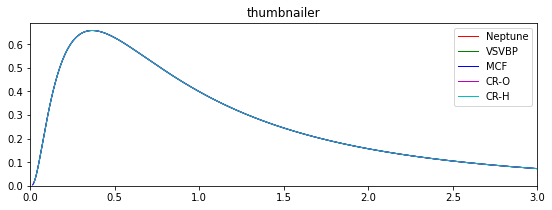

In [71]:
plt.subplot(1,2,1)
data_nept_2 = (data_nept-np.mean(data_nept))/np.std(data_nept)
data_vsvbp_2 = (data_vsvbp-np.mean(data_vsvbp))/np.std(data_vsvbp)
data_mcf_2 = (data_mcf-np.mean(data_mcf))/np.std(data_mcf)
data_cro_2 = (data_cro-np.mean(data_cro))/np.std(data_cro)
data_crh_2 = (data_crh-np.mean(data_crh))/np.std(data_crh)

mu_nept = np.mean(data_nept_2)
mu_vsvbp = np.mean(data_vsvbp_2)
mu_mcf = np.mean(data_mcf_2)
mu_cro = np.mean(data_cro_2)
mu_crh = np.mean(data_crh_2)

sigma_nept = np.std(data_nept_2) 
sigma_vsvbp = np.std(data_vsvbp_2) 
sigma_mcf = np.std(data_mcf_2) 
sigma_cro = np.std(data_cro_2) 
sigma_crh = np.std(data_crh_2) 

s_neptune = np.random.lognormal(mean=mu_nept, sigma=sigma_nept, size=10000)
s_vsvbp = np.random.lognormal(mean=mu_vsvbp, sigma=sigma_vsvbp, size=10000)
s_mcf = np.random.lognormal(mean=mu_mcf, sigma=sigma_mcf, size=10000)
s_cro = np.random.lognormal(mean=mu_cro, sigma=sigma_cro, size=10000)
s_crh = np.random.lognormal(mean=mu_crh, sigma=sigma_crh, size=10000)


countn, binsn, ignoredn = plt.hist(s_neptune, 100, density=True, align='mid',alpha=0)
countv, binsv, ignoredv = plt.hist(s_vsvbp, 100, density=True, align='mid',alpha=0)
countm, binsm, ignoredm = plt.hist(s_mcf, 100, density=True, align='mid',alpha=0)
counto, binso, ignoredo = plt.hist(s_cro, 100, density=True, align='mid',alpha=0)
counth, binsh, ignoredr = plt.hist(s_crh, 100, density=True, align='mid',alpha=0)

x_nept = np.linspace(min(binsn), max(binsn), 10000)
x_vsvbp = np.linspace(min(binsv), max(binsv), 10000)
x_mcf = np.linspace(min(binsm), max(binsm), 10000)
x_cro = np.linspace(min(binso), max(binso), 10000)
x_crh = np.linspace(min(binsh), max(binsh), 10000)

pdfn = (np.exp(-(np.log(x_nept) - mu_nept)**2 / (2 * sigma_nept**2))/ (x_nept * sigma_nept * np.sqrt(2 * np.pi)))
pdfv = (np.exp(-(np.log(x_vsvbp) - mu_vsvbp)**2 / (2 * sigma_vsvbp**2))/ (x_vsvbp * sigma_vsvbp * np.sqrt(2 * np.pi)))
pdfm = (np.exp(-(np.log(x_mcf) - mu_mcf)**2 / (2 * sigma_mcf**2))/ (x_mcf * sigma_mcf * np.sqrt(2 * np.pi)))
pdfo = (np.exp(-(np.log(x_cro) - mu_cro)**2 / (2 * sigma_cro**2))/ (x_cro * sigma_cro * np.sqrt(2 * np.pi)))
pdfh = (np.exp(-(np.log(x_crh) - mu_crh)**2 / (2 * sigma_crh**2))/ (x_crh * sigma_crh * np.sqrt(2 * np.pi)))

plt.plot(x_nept, pdfn, linewidth=1, color='r',label='Neptune')
plt.plot(x_vsvbp, pdfv, linewidth=1, color='g',label='VSVBP')
plt.plot(x_mcf, pdfm, linewidth=1, color='b',label='MCF')
plt.plot(x_cro, pdfo, linewidth=1, color='m',label='CR-O')
plt.plot(x_crh, pdfh, linewidth=1, color='c',label='CR-H')

plt.xlim([0,3])
plt.title(function)
plt.legend()
plt.show()